<p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:200%;text-align:center;border-radius:15px 15px;">Model Training for Credit Risk Prediction</p>

#### 1.1 Import Data and Required Packages
##### Importing Basic, Preprocessing and Model Training Library.

In [269]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns


#Preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler


# Modelling
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
import warnings
import shap
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.validation")


#### Import the CSV Data as Pandas DataFrame

In [270]:
df = pd.read_csv('data/credit_risk.csv')

In [271]:
#Dropping id column
df = df.drop(['Id'], axis=1)

In [272]:
#Fixing few outliers in Age, Income and Emp_length
df = df[(df['Age'] <= 80) & (df['Income'] <= 1000000) & (df['Emp_length'] <= 45)]

#### Treating missing values

In [273]:
df = df.dropna(subset=['Emp_length'])

#### Missing value treatment using groupwise mean imputation

In [274]:
df['Rate'] = df.groupby(['Home', 'Intent'])['Rate'].transform(lambda x: x.fillna(x.mean()))


In [275]:
#Converting Target label to 0 and 1
df['Default'] = df['Default'].replace({'N': 0, 'Y': 1}).astype(int)

#### Preparing X and Y variables

In [276]:
X = df.drop(columns=['Default','Status'],axis=1)
y = df['Default']

In [277]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(sparse_output=True))
])

numerical_transformer = Pipeline([
    ('scaler', StandardScaler())])


preprocessor = ColumnTransformer(
        transformers=[
        ("cat", categorical_transformer, cat_features),
         ("num", numerical_transformer, num_features),
        ]        
        ,remainder="passthrough"
)

# Create a pipeline that includes the preprocessor
pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

In [278]:
X_transform = pipeline.fit_transform(X)

In [279]:
# Get the transformed column names
transformed_column_names = []

if len(cat_features) > 0:
    onehot_encoder = pipeline.named_steps['preprocessor'].transformers_[0][1].named_steps['onehot']
    feature_names = onehot_encoder.get_feature_names_out(input_features=cat_features)
    transformed_column_names.extend(feature_names)

# Append numerical column names
transformed_column_names.extend(num_features)


In [280]:
#creating three sets - training, test and validation
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X_transform, y, test_size=0.1, random_state=42)

# Splitting temporary set into validation and test sets
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.20, random_state=42)

In [281]:
# Initialize the random undersampler
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Apply the undersampler to the training data
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Count the number of samples in each class after undersampling
resampled_class_counts = pd.Series(y_train_resampled).value_counts()
print("Class distribution after undersampling:\n", resampled_class_counts)

Class distribution after undersampling:
 Default
0    4035
1    4035
Name: count, dtype: int64


#### Create an Evaluate Function to give all metrics after model Training

In [282]:
def evaluate_model(true, predicted):
     # Calculate accuracy
    accuracy = accuracy_score(true, predicted)
    precision = precision_score(true, predicted)
    recall = recall_score(true, predicted)
    f1 = f1_score(true, predicted)
    # Calculate ROC AUC
    roc_auc = roc_auc_score(true, predicted)
    
    return accuracy, precision, recall, f1,roc_auc


In [283]:
#Trying out different models for the best performance
models = {
    "Logistic Regression": LogisticRegression(),
    "XGBClassifier": XGBClassifier(verbose=0),
    "CatBoost Classifier": CatBoostClassifier(verbose=False),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(),
    "Light GBM Classifier":lgb.LGBMClassifier(),
}

In [284]:
# Defining Hyper Parameters for fine tuning and selecting the best model

params = {
    "Logistic Regression": {
        "C": [0.001, 0.01, 0.1, 1, 10],
        "penalty": ["l1", "l2"]
    },
    "XGBClassifier": {
        "learning_rate": [0.01, 0.1, 0.2],
        "n_estimators": [100, 200, 300],
        "max_depth": [3, 4, 5,10,20],
        "min_child_weight": [1, 2, 3],
        "subsample": [0.8, 0.9, 1.0],
        "colsample_bytree": [0.8, 0.9, 1.0]
    },
    "CatBoost Classifier": {
        "iterations": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.2],
        "depth": [3, 4, 5,10,20],
        "l2_leaf_reg": [1, 3, 5, 7, 9]
    },
    "Decision Tree": {
        "max_depth": [10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "criterion": ["gini", "entropy"]
    },
    "Random Forest Classifier": {
        "n_estimators": [100, 200, 300],
        "max_depth": [10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "criterion": ["gini", "entropy"]
    },
    "Light GBM Classifier": {
        "learning_rate": [0.01, 0.1, 0.2],
        "n_estimators": [100, 200, 300],
        "max_depth": [3, 4, 5,10,20],
        "num_leaves": [31, 63, 127]
    }
}

### Running Hyper Parameter tuning for different models

In [285]:
#Defining data_list to get the performance benchmark for all models

data_list = []

from sklearn.metrics import make_scorer, recall_score

# Define a custom scorer for recall
scorer = make_scorer(recall_score, average='binary') 

#Hyper parameter tuning for each model in the original list across different params
for i in range(len(list(models))):
    model = list(models.values())[i]
    para=params[list(models.keys())[i]]
    
    gs = RandomizedSearchCV(model, param_distributions=para,n_iter=10, scoring='accuracy', n_jobs=-1, cv=5, verbose=0, random_state=42)
  
    gs.fit(X_train_resampled,y_train_resampled)
    
    best_params = gs.best_params_
    best_estimator = gs.best_estimator_

    best_model = model.set_params(**best_params)
    
    best_model.fit(X_train_resampled,y_train_resampled)

    # Make predictions
    y_train_pred = best_model.predict(X_train_resampled)
    y_val_pred = best_model.predict(X_val)
    
    # Evaluate Train and Test dataset
    model_train_accuracy,model_train_precision,model_train_recall,model_train_f1,train_roc_auc = evaluate_model(y_train_resampled, y_train_pred)

    model_test_accuracy, model_test_precision, model_test_recall,model_test_f1,test_roc_auc = evaluate_model(y_val, y_val_pred)
        
    print(list(models.keys())[i])
    
    # Print the best parameters and best score
    print("Best Parameters:", best_params)
    
    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print("- Precision: {:.4f}".format(model_train_precision))
    print("- Recall: {:.4f}".format(model_train_recall))
    print("- F1 score: {:.4f}".format(model_train_f1))
    print("- ROC AUC: {:.4f}".format(train_roc_auc))

    print('----------------------------------')
    
    #REporting the performance for validation set
    print('Model performance for Validation set')
    print("- Accuracy: {:.4f}".format(model_test_accuracy))
    print("- Precision: {:.4f}".format(model_test_precision))
    print("- Recall: {:.4f}".format(model_test_recall))
    print("- F1 score: {:.4f}".format(model_test_f1))
    print("- ROC AUC: {:.4f}".format(test_roc_auc))
      
    data_list.append({'Model': list(models.keys())[i], 'BestAccuracy': model_test_accuracy,'Recall':model_test_recall,'Precision':model_test_precision,'ROC_AUC':test_roc_auc, 'ModelParams': best_params})
    
    print('='*35)
    print('\n')

/Users/kianathakkar/Documents/CreditRiskPrediction/myenv/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kianathakkar/Documents/CreditRiskPrediction/myenv/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kianathakkar/Documents/CreditRiskPrediction/myenv/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kianathakkar/Documents/CreditRiskPrediction/myenv/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarni

Logistic Regression
Best Parameters: {'penalty': 'l2', 'C': 1}
Model performance for Training set
- Accuracy: 0.8270
- Precision: 0.8097
- Recall: 0.8550
- F1 score: 0.8317
- ROC AUC: 0.8270
----------------------------------
Model performance for Validation set
- Accuracy: 0.8067
- Precision: 0.4871
- Recall: 0.8615
- F1 score: 0.6223
- ROC AUC: 0.8279




/Users/kianathakkar/Documents/CreditRiskPrediction/myenv/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/kianathakkar/Documents/CreditRiskPrediction/myenv/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/kianathakkar/Documents/CreditRiskPrediction/myenv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [14:27:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/kianathakkar/Documents/CreditRiskPrediction/myenv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [14:27:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: 

XGBClassifier
Best Parameters: {'subsample': 0.9, 'n_estimators': 200, 'min_child_weight': 2, 'max_depth': 20, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Model performance for Training set
- Accuracy: 0.9154
- Precision: 0.8697
- Recall: 0.9772
- F1 score: 0.9203
- ROC AUC: 0.9154
----------------------------------
Model performance for Validation set
- Accuracy: 0.8021
- Precision: 0.4818
- Recall: 0.9288
- F1 score: 0.6345
- ROC AUC: 0.8511




/Users/kianathakkar/Documents/CreditRiskPrediction/myenv/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kianathakkar/Documents/CreditRiskPrediction/myenv/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kianathakkar/Documents/CreditRiskPrediction/myenv/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kianathakkar/Documents/CreditRiskPrediction/myenv/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarni

CatBoost Classifier
Best Parameters: {'learning_rate': 0.2, 'l2_leaf_reg': 7, 'iterations': 300, 'depth': 4}
Model performance for Training set
- Accuracy: 0.8906
- Precision: 0.8471
- Recall: 0.9532
- F1 score: 0.8970
- ROC AUC: 0.8906
----------------------------------
Model performance for Validation set
- Accuracy: 0.8069
- Precision: 0.4881
- Recall: 0.9137
- F1 score: 0.6363
- ROC AUC: 0.8482




/Users/kianathakkar/Documents/CreditRiskPrediction/myenv/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kianathakkar/Documents/CreditRiskPrediction/myenv/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kianathakkar/Documents/CreditRiskPrediction/myenv/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kianathakkar/Documents/CreditRiskPrediction/myenv/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarni

Decision Tree
Best Parameters: {'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10, 'criterion': 'entropy'}
Model performance for Training set
- Accuracy: 0.8683
- Precision: 0.8321
- Recall: 0.9227
- F1 score: 0.8751
- ROC AUC: 0.8683
----------------------------------
Model performance for Validation set
- Accuracy: 0.8002
- Precision: 0.4784
- Recall: 0.8918
- F1 score: 0.6227
- ROC AUC: 0.8356




/Users/kianathakkar/Documents/CreditRiskPrediction/myenv/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kianathakkar/Documents/CreditRiskPrediction/myenv/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kianathakkar/Documents/CreditRiskPrediction/myenv/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kianathakkar/Documents/CreditRiskPrediction/myenv/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarni

Random Forest Classifier
Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 30, 'criterion': 'entropy'}
Model performance for Training set
- Accuracy: 0.9673
- Precision: 0.9465
- Recall: 0.9906
- F1 score: 0.9680
- ROC AUC: 0.9673
----------------------------------
Model performance for Validation set
- Accuracy: 0.8099
- Precision: 0.4920
- Recall: 0.8748
- F1 score: 0.6298
- ROC AUC: 0.8349




/Users/kianathakkar/Documents/CreditRiskPrediction/myenv/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kianathakkar/Documents/CreditRiskPrediction/myenv/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/kianathakkar/Documents/CreditRiskPrediction/myenv/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kianathakkar/Documents/CreditRiskPrediction/myenv/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarni

Light GBM Classifier
Best Parameters: {'num_leaves': 31, 'n_estimators': 300, 'max_depth': 20, 'learning_rate': 0.01}
Model performance for Training set
- Accuracy: 0.8742
- Precision: 0.8314
- Recall: 0.9388
- F1 score: 0.8819
- ROC AUC: 0.8742
----------------------------------
Model performance for Validation set
- Accuracy: 0.8083
- Precision: 0.4901
- Recall: 0.9165
- F1 score: 0.6387
- ROC AUC: 0.8501




### Results - XGboost gives good results on training as well as test data

In [286]:
data = pd.DataFrame(data_list)

# Sort the DataFrame by the 'Best Scire' in descending order
data = data.sort_values(by='Recall', ascending=False)

# Reset the index to have continuous index values
data.reset_index(drop=True, inplace=True)

# Print the resulting sorted DataFrame
print(data)

                      Model  BestAccuracy    Recall  Precision   ROC_AUC  \
0             XGBClassifier      0.802140  0.928843   0.481791  0.851122   
1      Light GBM Classifier      0.808279  0.916509   0.490107  0.850120   
2       CatBoost Classifier      0.806876  0.913662   0.488089  0.848159   
3             Decision Tree      0.800210  0.891841   0.478372  0.835634   
4  Random Forest Classifier      0.809858  0.874763   0.491996  0.834950   
5       Logistic Regression      0.806701  0.861480   0.487124  0.827878   

                                         ModelParams  
0  {'subsample': 0.9, 'n_estimators': 200, 'min_c...  
1  {'num_leaves': 31, 'n_estimators': 300, 'max_d...  
2  {'learning_rate': 0.2, 'l2_leaf_reg': 7, 'iter...  
3  {'min_samples_split': 10, 'min_samples_leaf': ...  
4  {'n_estimators': 100, 'min_samples_split': 2, ...  
5                          {'penalty': 'l2', 'C': 1}  


### Final Model - Light GBM Classifier

In [287]:
model_name = 'Light GBM Classifier'

# model_name = 'XGBClassifier'

final_model = models[model_name]

final_params = data[data['Model'] == model_name]['ModelParams'].values[0]

xgb = final_model.set_params(**final_params)

xgb_trained = xgb.fit(X_train_resampled, y_train_resampled)


In [288]:
y_scores = xgb_trained.predict_proba(X_test)[:, 1]

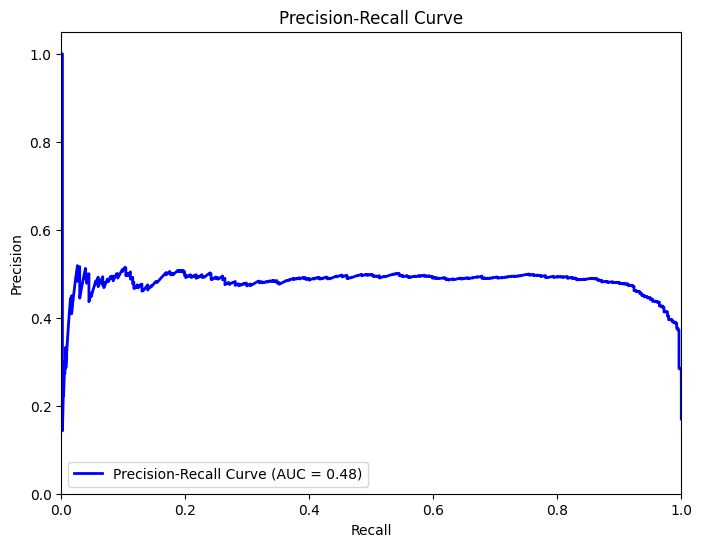

Optimal Threshold for Maximum F1-Score: 0.5504668942382652


In [289]:
# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Calculate the area under the precision-recall curve (AUC-PR)
auc_pr = auc(recall, precision)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall Curve (AUC = %0.2f)' % auc_pr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower left")
plt.title('Precision-Recall Curve')
plt.show()

# Find the threshold that balances precision and recall
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold_pr = thresholds[np.argmax(f1_scores)]

print("Optimal Threshold for Maximum F1-Score:", optimal_threshold_pr)

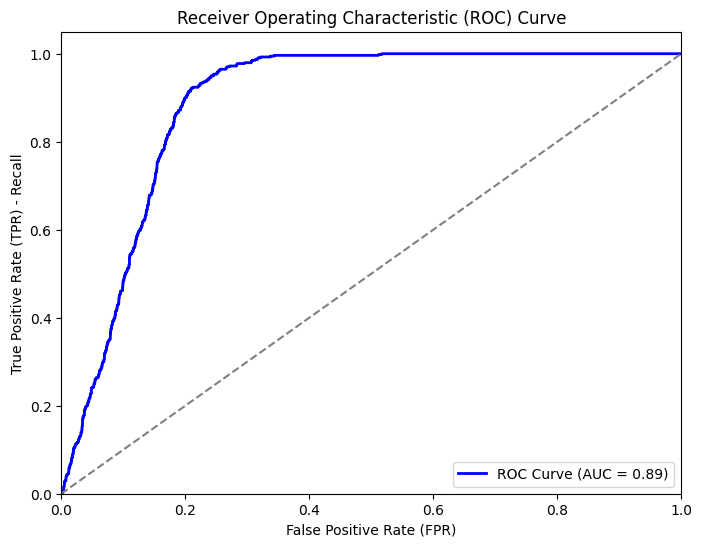

In [290]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calculate the area under the ROC curve (AUC-ROC)
auc_roc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label='ROC Curve (AUC = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) - Recall')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

In [291]:
# Calculate Youden's J Statistic for each threshold
youden_j = tpr - fpr

# Find the index of the threshold that maximizes Youden's J
optimal_threshold_index = np.argmax(youden_j)

# Get the optimal threshold value
optimal_threshold = thresholds[optimal_threshold_index]

print(optimal_threshold)

0.5260058732462491


In [292]:
y_test_pred = (y_scores >= optimal_threshold).astype(int)

y_val_scores =  xgb_trained.predict_proba(X_val)[:, 1]

y_val_pred = (y_val_scores >= optimal_threshold).astype(int)

test_accuracy,test_precision,test_recall,test_f1,test_roc_auc = evaluate_model(y_test, y_test_pred)

val_accuracy , val_precision,val_recall,val_f1,val_roc_auc = evaluate_model(y_val, y_val_pred)

print(" Precision of the model on test set is %.2f" %test_precision)

print(" Recall of the model on test set is %.2f" %test_recall)

print(" ROC AUC of the model on test set is %.2f" %test_roc_auc)

print(" Precision of the model on validation set is %.2f" %val_precision)

print(" Recall of the model on validation set is %.2f" %val_recall)

print(" ROC AUC of the model on validation set is %.2f" %val_roc_auc)

 Precision of the model on test set is 0.47
 Recall of the model on test set is 0.92
 ROC AUC of the model on test set is 0.86
 Precision of the model on validation set is 0.50
 Recall of the model on validation set is 0.91
 ROC AUC of the model on validation set is 0.85


## Getting feature importance

In [293]:
feature_importance = xgb.feature_importances_

# Create a dictionary of feature names and feature importance scores
feature_importance_mapping = {}
for i, col_name in enumerate(transformed_column_names):
    feature_importance_mapping[col_name] = feature_importance[i]
    
# Sort the feature importance dictionary by score in descending order
sorted_feature_importance = sorted(feature_importance_mapping.items(), key=lambda x: x[1], reverse=True)

# Create a DataFrame from the sorted feature importances
df_feature_imp = pd.DataFrame(sorted_feature_importance, columns=["Feature", "Importance"])

In [294]:
pd.set_option('display.max_rows', None)

df_feature_imp

,Feature,Importance
0,Rate,4320
1,Income,978
2,Amount,847
3,Percent_income,704
4,Age,556
5,Emp_length,507
6,Cred_length,399
7,Home_OWN,177
8,Intent_HOMEIMPROVEMENT,154
9,Home_RENT,131


<Axes: ylabel='Feature'>

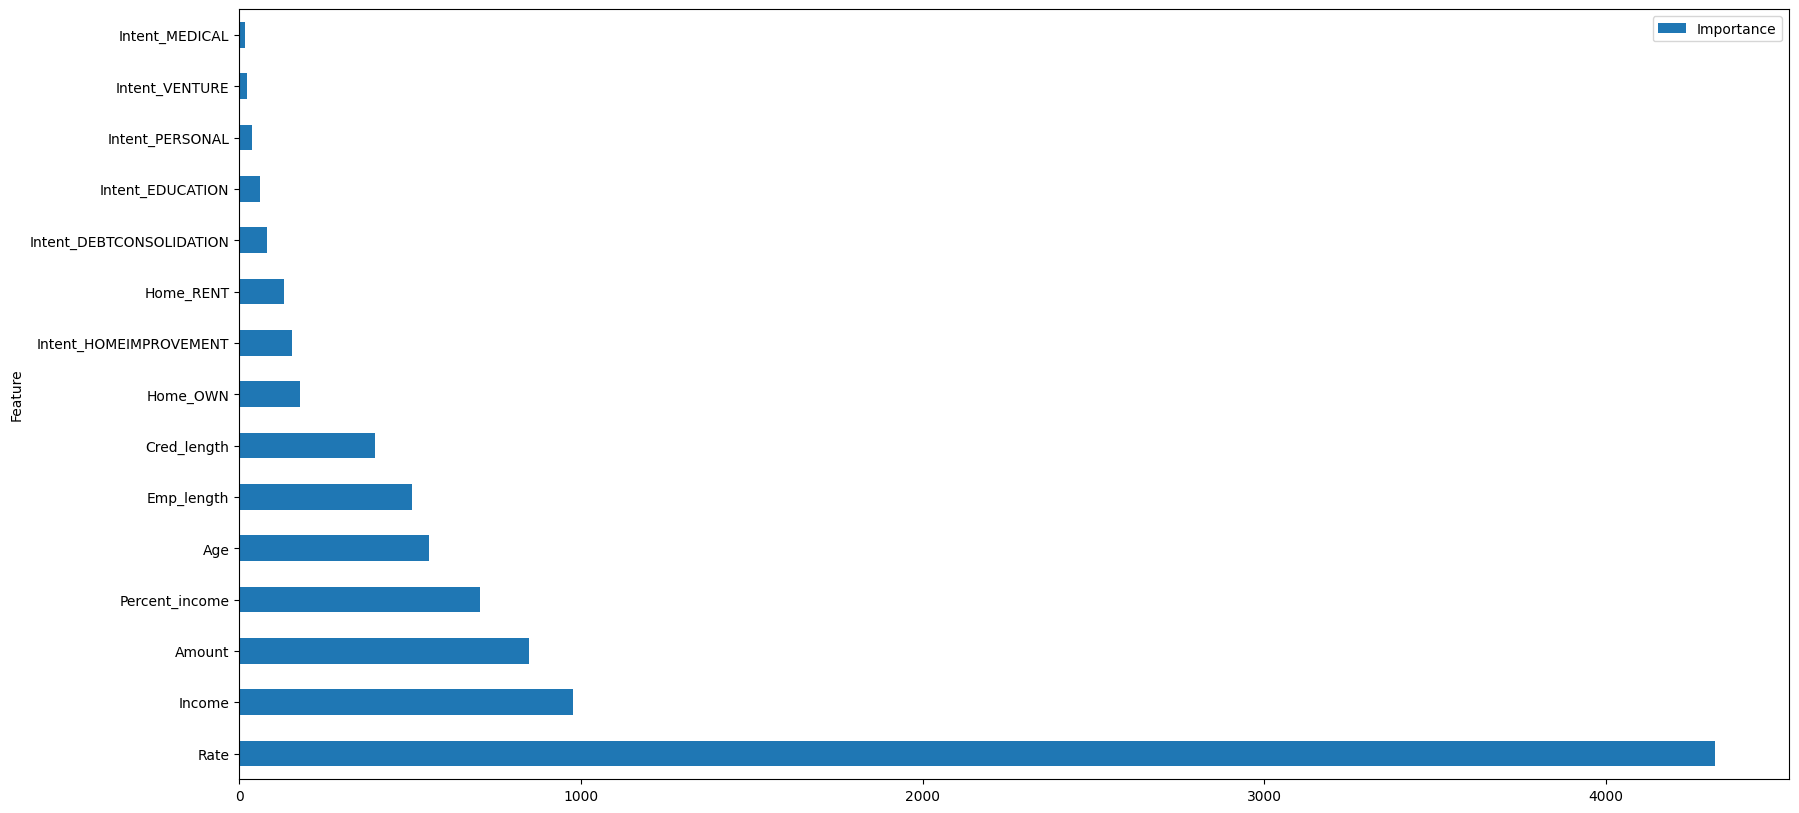

In [295]:
df_feature_imp.nlargest(15, columns="Importance").reset_index(drop=True).plot(kind='barh', y='Importance', x='Feature', figsize=(20, 10))

In [296]:
# Create a SHAP explainer object for the model
explainer = shap.TreeExplainer(xgb_trained)

In [349]:
df_default = df[df['Default']==1]

df_default = df_default.head(1000)

X_sample = df_default.drop(columns=['Default','Status'],axis=1)
y_sample = df_default['Default']

X_sample_transform = pipeline.transform(X_sample)


In [350]:
#Compute SHAP values for the provided data
shap_values = explainer.shap_values(X_sample_transform)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [351]:
df_default.head(10)

,Age,Income,Home,Emp_length,Intent,Amount,Rate,Status,Percent_income,Default,Cred_length
4,24,54400,RENT,8.0,MEDICAL,35000,14.270000,1,0.55,1,4
21,25,137000,RENT,9.0,PERSONAL,34800,16.770000,0,0.25,1,2
24,22,80000,RENT,3.0,PERSONAL,33950,14.540000,1,0.42,1,4
26,21,11000,MORTGAGE,3.0,VENTURE,4575,17.740000,1,0.42,1,3
29,21,11389,OTHER,5.0,EDUCATION,4000,12.840000,1,0.35,1,2
32,26,95000,RENT,7.0,HOMEIMPROVEMENT,31050,14.170000,1,0.33,1,3
37,24,64000,RENT,8.0,DEBTCONSOLIDATION,30000,14.540000,1,0.47,1,3
38,25,75000,RENT,4.0,HOMEIMPROVEMENT,30000,16.890000,1,0.40,1,4
43,23,300000,OWN,1.0,EDUCATION,24250,19.410000,0,0.08,1,2
50,24,78000,RENT,4.0,DEBTCONSOLIDATION,30000,11.394214,1,0.38,1,4


In [352]:
# You can visualize SHAP values for a specific prediction (e.g., the first instance in your sample)
shap.initjs()  

prediction_class = 1

record_index = 4

# Extract the SHAP values for the chosen record
shap_values_for_record = shap_values[prediction_class]

shap.force_plot(explainer.expected_value[prediction_class], shap_values_for_record[record_index,:],X_sample_transform[record_index],feature_names=transformed_column_names)

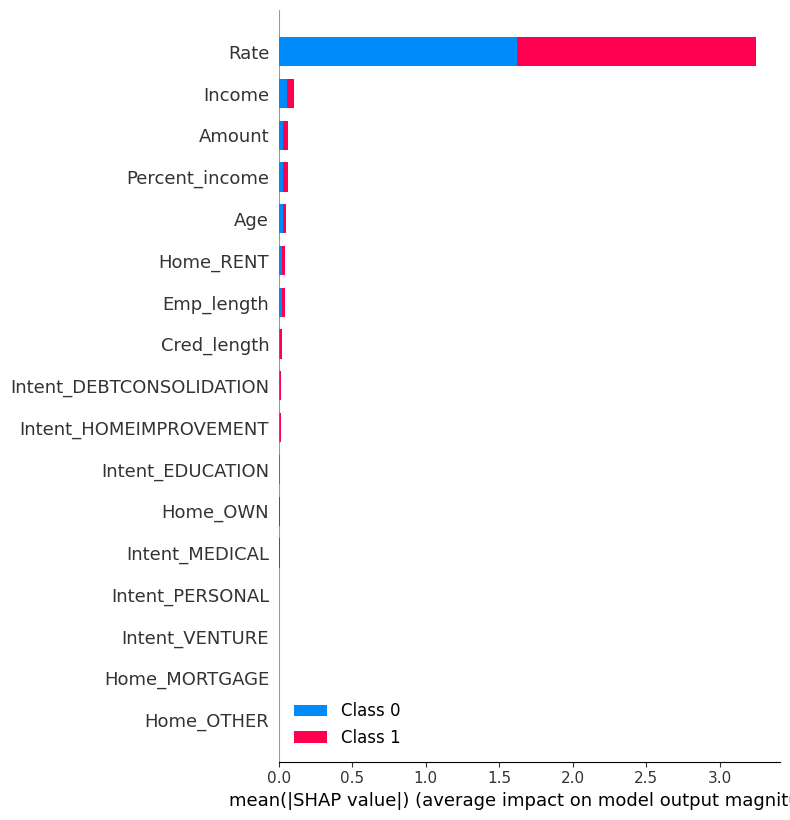

In [338]:
shap.summary_plot(shap_values, X_sample_transform, feature_names=transformed_column_names, plot_type="bar")

## Model Training using Tensorflow (Neural Net)

In [86]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras import initializers
from keras.utils import to_categorical
from tensorflow.keras import metrics
import numpy as np

In [71]:
# Convert the CSR matrix to a dense Numpy array
X_dense = X_train_resampled

# Convert the Pandas Series to a Numpy array
Y_array = y_train_resampled.values.reshape(-1,1)

# Assuming Y_array contains class labels (0 or 1)
y_encoded = to_categorical(Y_array, num_classes=2)

y_val_array = y_val.values.reshape(-1,1)

y_val_encoded = to_categorical(y_val_array, num_classes=2)

# Create a Keras Sequential model
model = Sequential()

# Add your layers here

model.add(Dense(128, activation='relu', kernel_initializer=initializers.he_normal()))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_initializer=initializers.he_normal()))  
model.add(Dense(2, activation='sigmoid',kernel_initializer=initializers.glorot_normal()))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=[metrics.Recall()])

# Fit the model
history = model.fit(X_dense,y_encoded, epochs=100, batch_size=32,validation_data=(X_val,y_val_encoded))

Epoch 1/100
253/253 [==============================] - 0s 1ms/step - loss: 0.5252 - recall_1: 0.4000 - val_loss: 0.5358 - val_recall_1: 0.4611
Epoch 2/100
253/253 [==============================] - 0s 724us/step - loss: 0.4759 - recall_1: 0.4912 - val_loss: 0.4394 - val_recall_1: 0.5327
Epoch 3/100
253/253 [==============================] - 0s 722us/step - loss: 0.4575 - recall_1: 0.5399 - val_loss: 0.4516 - val_recall_1: 0.5655
Epoch 4/100
253/253 [==============================] - 0s 715us/step - loss: 0.4500 - recall_1: 0.5813 - val_loss: 0.4561 - val_recall_1: 0.6001
Epoch 5/100
253/253 [==============================] - 0s 706us/step - loss: 0.4430 - recall_1: 0.6032 - val_loss: 0.4781 - val_recall_1: 0.5848
Epoch 6/100
253/253 [==============================] - 0s 720us/step - loss: 0.4423 - recall_1: 0.6254 - val_loss: 0.4542 - val_recall_1: 0.5774
Epoch 7/100
253/253 [==============================] - 0s 720us/step - loss: 0.4359 - recall_1: 0.5998 - val_loss: 0.4453 - val_reca

In [72]:
X_test_dense = X_test

# Make predictions
y_test_pred = model.predict(X_test_dense)

y_test_pred_labels = np.argmax(y_test_pred, axis=1)

# Calculate score for the test data
accuracy_test,precision_test,recall_test,f1_test,roc_auc = evaluate_model(y_test, y_test_pred_labels)

# Print the RMSE and R2 score for the test data
print(f"Accuracy (Test): {accuracy_test:.2f}")
print(f"Precision (Test): {precision_test:.2f}")
print(f"Recall (Test): {recall_test:.2f}")
print(f"F1 (Test): {f1_test:.2f}")
print(f"ROC AUC (Test): {roc_auc:.2f}")

99/99 [==============================] - 0s 310us/step
Accuracy (Test): 0.80
Precision (Test): 0.45
Recall (Test): 0.85
F1 (Test): 0.59
ROC AUC (Test): 0.82


### Trying Hyper Param Tuning on Neural Net

In [73]:
import kerastuner as kt

In [74]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('dense_units', min_value=32, max_value=256, step=32),
        activation=hp.Choice('dense_activation', values=['relu', 'tanh']),
        kernel_initializer=initializers.he_normal()
    ))
    model.add(Dropout(hp.Float('dropout', min_value=0.3, max_value=0.7, step=0.1)))
    model.add(Dense(64, activation='relu', kernel_initializer=initializers.he_normal()))
    model.add(Dense(2, activation='sigmoid', kernel_initializer=initializers.glorot_normal()))
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=[keras.metrics.Recall()]
    )
    
    return model


In [75]:
objective = kt.Objective("val_recall", direction="max")

tuner = kt.Hyperband(
    build_model,
    objective=objective,
    max_epochs=30,
    factor=3,
    directory='notebook/data',
    project_name='CreditRisk'
)

In [76]:
# Perform the hyperparameter search
tuner.search(
    X_dense,
    y_encoded,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val_encoded)
)

Trial 90 Complete [00h 00m 06s]
val_recall: 0.5870899558067322

Best val_recall So Far: 0.999649167060852
Total elapsed time: 00h 02m 25s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [77]:
# Get the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

In [82]:
# Build the best model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Fit the best model with the best hyperparameters
best_model.fit(X_dense, y_encoded, epochs=100, batch_size=32, validation_data=(X_val, y_val_encoded))

Epoch 1/100
253/253 [==============================] - 0s 1ms/step - loss: 0.4761 - recall_1: 0.4942 - val_loss: 0.5282 - val_recall_1: 0.5013
Epoch 2/100
253/253 [==============================] - 0s 698us/step - loss: 0.4418 - recall_1: 0.4160 - val_loss: 0.4198 - val_recall_1: 0.5774
Epoch 3/100
253/253 [==============================] - 0s 832us/step - loss: 0.4301 - recall_1: 0.3830 - val_loss: 0.4375 - val_recall_1: 0.5787
Epoch 4/100
253/253 [==============================] - 0s 779us/step - loss: 0.4272 - recall_1: 0.3827 - val_loss: 0.4603 - val_recall_1: 0.5962
Epoch 5/100
253/253 [==============================] - 0s 722us/step - loss: 0.4224 - recall_1: 0.4258 - val_loss: 0.4398 - val_recall_1: 0.6253
Epoch 6/100
253/253 [==============================] - 0s 712us/step - loss: 0.4211 - recall_1: 0.3918 - val_loss: 0.4516 - val_recall_1: 0.6078
Epoch 7/100
253/253 [==============================] - 0s 704us/step - loss: 0.4255 - recall_1: 0.3913 - val_loss: 0.4468 - val_reca

In [83]:
# Make predictions
y_test_pred = best_model.predict(X_test_dense)

y_test_pred_labels = np.argmax(y_test_pred, axis=1)

# Calculate score for the test data
accuracy_test,precision_test,recall_test,f1_test,roc_auc = evaluate_model(y_test, y_test_pred_labels)

# Print the RMSE and R2 score for the test data
print(f"Accuracy (Test): {accuracy_test:.2f}")
print(f"Precision (Test): {precision_test:.2f}")
print(f"Recall (Test): {recall_test:.2f}")
print(f"F1 (Test): {f1_test:.2f}")
print(f"ROC AUC (Test): {roc_auc:.2f}")

99/99 [==============================] - 0s 292us/step
Accuracy (Test): 0.81
Precision (Test): 0.47
Recall (Test): 0.86
F1 (Test): 0.60
ROC AUC (Test): 0.83


### Conclusion
1. Even Neural Network gave good accuracy
2. We would use Light GBM for prediction for ease of implementation